## Decision tree model

### Cargar datos

In [1]:
import pandas as pd

# Cargar el dataset
data = pd.read_csv("../datasets_limpios/credit_data_clean.csv")

# Separar variables predictoras (X) y variable objetivo (y)
X = data.drop(columns=["target"])
y = data["target"]


### Entrenar modelo

In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

# Identificar columnas categóricas
cat_cols = X.select_dtypes(include=['object']).columns

# Codificar solo las categóricas
if len(cat_cols) > 0:
    encoder = OrdinalEncoder()
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

# Entrenar el árbol de decisión
tree_model = DecisionTreeClassifier(max_depth=4, criterion="gini", random_state=42)
tree_model.fit(X, y)


DecisionTreeClassifier(max_depth=4, random_state=42)

### Visualizacion del Arbol

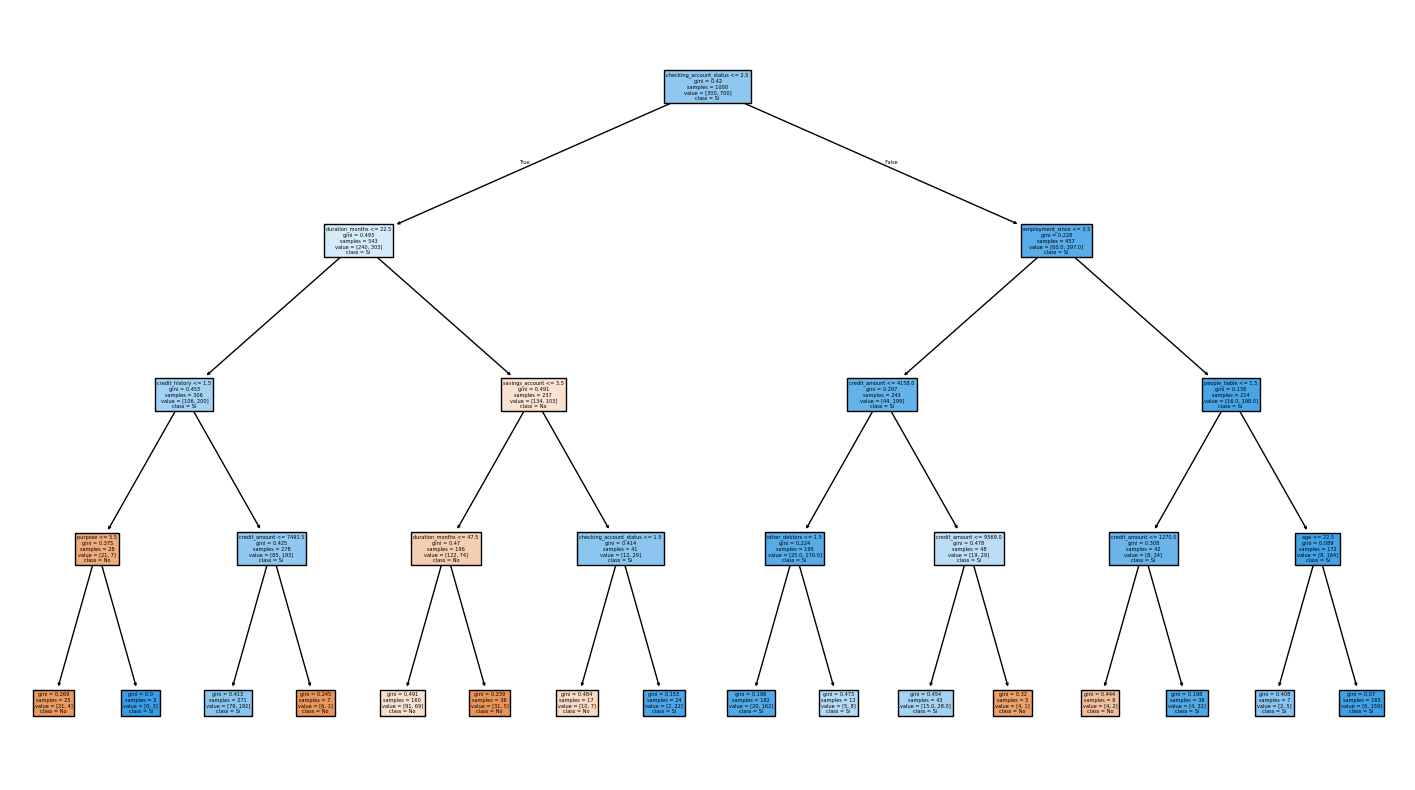

In [8]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))
tree.plot_tree(
    tree_model,                    # usa el modelo entrenado
    feature_names=X.columns,
    class_names=["No", "Sí"],
    filled=True
)
plt.show()


### Extraccion de Reglas explicitas

In [9]:
from sklearn.tree import _tree

def extract_rules(model, feature_names):
    tree_ = model.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []

    def recurse(node, depth, rule):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Recursión izquierda
            recurse(tree_.children_left[node], depth + 1, 
                    rule + [f"{name} <= {threshold:.2f}"])
            # Recursión derecha
            recurse(tree_.children_right[node], depth + 1, 
                    rule + [f"{name} > {threshold:.2f}"])
        else:
            pred_class = tree_.value[node][0].argmax()
            rules.append({
                "rule": " and ".join(rule),
                "prediction": pred_class
            })
    
    recurse(0, 1, [])
    return rules

# 👇 Usa el modelo correcto (NO el módulo)
rules = extract_rules(tree_model, X.columns)

# Mostrar algunas reglas
for r in rules[:10]:
    print(f"SI {r['rule']} → clase {r['prediction']}")


SI checking_account_status <= 2.50 and duration_months <= 22.50 and credit_history <= 1.50 and purpose <= 5.50 → clase 0
SI checking_account_status <= 2.50 and duration_months <= 22.50 and credit_history <= 1.50 and purpose > 5.50 → clase 1
SI checking_account_status <= 2.50 and duration_months <= 22.50 and credit_history > 1.50 and credit_amount <= 7491.50 → clase 1
SI checking_account_status <= 2.50 and duration_months <= 22.50 and credit_history > 1.50 and credit_amount > 7491.50 → clase 0
SI checking_account_status <= 2.50 and duration_months > 22.50 and savings_account <= 3.50 and duration_months <= 47.50 → clase 0
SI checking_account_status <= 2.50 and duration_months > 22.50 and savings_account <= 3.50 and duration_months > 47.50 → clase 0
SI checking_account_status <= 2.50 and duration_months > 22.50 and savings_account > 3.50 and checking_account_status <= 1.50 → clase 0
SI checking_account_status <= 2.50 and duration_months > 22.50 and savings_account > 3.50 and checking_acco

📊 MÉTRICAS DEL MODELO (Decision Tree)
Accuracy:   0.730
Precision:  0.761
Recall:     0.895
F1-score:   0.823
ROC-AUC:    0.713
PR-AUC:     0.830

🧩 Matriz de confusión:
[[ 31  59]
 [ 22 188]]


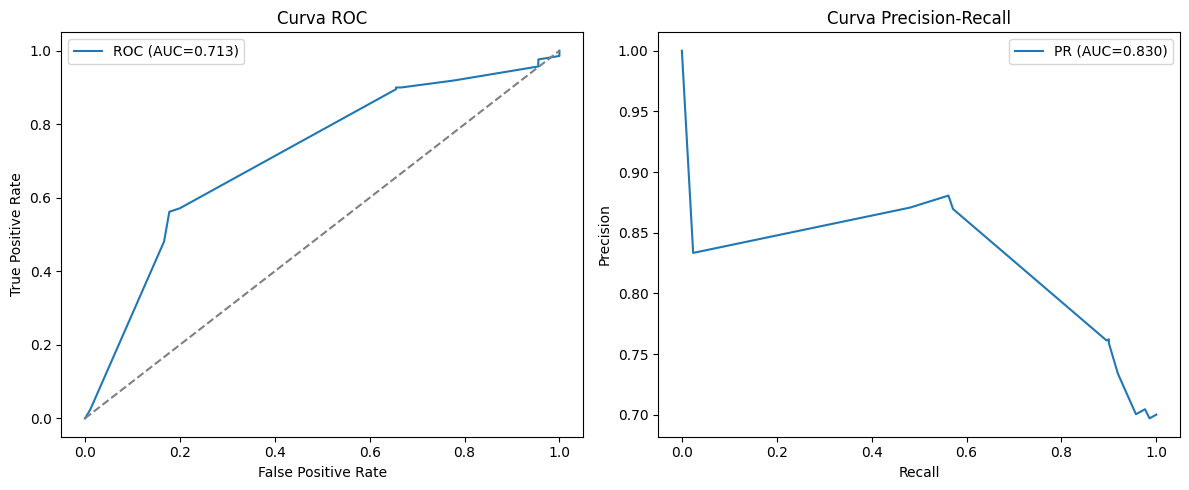

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix,
    precision_recall_curve
)
from sklearn.tree import DecisionTreeClassifier

# 🔹 Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 🔹 Entrenar modelo
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# 🔹 Predicciones
y_pred = tree_model.predict(X_test)
y_proba = tree_model.predict_proba(X_test)[:, 1]  # probas clase positiva

# 🔹 Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recalls, precisions)

print("📊 MÉTRICAS DEL MODELO (Decision Tree)")
print(f"Accuracy:   {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall:     {rec:.3f}")
print(f"F1-score:   {f1:.3f}")
print(f"ROC-AUC:    {roc_auc:.3f}")
print(f"PR-AUC:     {pr_auc:.3f}")

# 🔹 Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\n🧩 Matriz de confusión:")
print(cm)

# 🔹 Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()

# 🔹 Curva Precision-Recall
plt.subplot(1,2,2)
plt.plot(recalls, precisions, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()

plt.tight_layout()
plt.show()


- Estabilidad: El árbol de decisión tiene baja varianza esperada si se limita la profundidad (max_depth=4), 
  pero sigue siendo sensible a pequeñas variaciones de los datos. 
  Se puede estabilizar con técnicas como bagging (RandomForest).

- Robustez ante desbalance: El modelo puede sesgarse hacia la clase mayoritaria, 
  ya que el criterio Gini no compensa el desbalance. 
  Puede mejorarse ajustando class_weight='balanced' o calibrando el umbral.

- Sensibilidad al umbral: Al modificar el umbral de decisión (por defecto 0.5), 
  se puede desplazar el trade-off entre precisión y recall. 
  Las curvas ROC y PR muestran claramente ese equilibrio entre detectar positivos y evitar falsos positivos.

In [13]:
import joblib
import os

os.makedirs("modelos_guardados", exist_ok=True)

modelo_nombre = "decision_tree.pkl"  # Cambia por: "arbol_decision.pkl", "log_reg.pkl", "red_neuronal.pkl", etc.

joblib.dump(tree_model, f"modelos_guardados/{modelo_nombre}")

print(f"✅ Modelo guardado correctamente en: modelos_guardados/{modelo_nombre}")



✅ Modelo guardado correctamente en: modelos_guardados/decision_tree.pkl
